In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
torch.__version__


'2.3.0+cu121'

# visualisation

## 1. DATA (preparing data and loading data)
* excel spreadsheet
* images

In [2]:
# lets create *known * parameter
X = torch.arange(0, 10, 0.2).unsqueeze(dim=1)#dim=1 is to make it 2D an column vector
Y= 2*X + 1 + 0.1
len(X), len(Y)

(50, 50)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)#random_state is to make the split radnomly deterministic 
len(X_train), len(X_test),len(Y_train), len(Y_test)

(40, 10, 40, 10)

In [4]:
X_train

tensor([[2.4000],
        [0.8000],
        [7.4000],
        [1.6000],
        [0.6000],
        [1.2000],
        [8.2000],
        [9.2000],
        [9.4000],
        [3.0000],
        [1.8000],
        [3.2000],
        [4.8000],
        [6.8000],
        [6.2000],
        [0.0000],
        [8.8000],
        [5.4000],
        [6.6000],
        [1.0000],
        [5.8000],
        [2.2000],
        [7.2000],
        [0.2000],
        [4.2000],
        [0.4000],
        [8.6000],
        [7.0000],
        [4.6000],
        [8.0000],
        [2.0000],
        [4.4000],
        [3.6000],
        [9.8000],
        [4.0000],
        [1.4000],
        [8.4000],
        [2.8000],
        [5.6000],
        [7.6000]])

In [5]:
def plot_pridictions(train_data=X_train, train_labels=Y_train, test_data=X_test, test_labels=Y_test, pred=None):
    
    plt.figure(figsize=(12, 6))
    plt.scatter(train_data, train_labels, c='b', label='Train data')
    plt.scatter(test_data, test_labels, c='g', label='Test data')
    if pred is not None:
        plt.plot(test_data, pred, c='r', label='Predictions')#
    plt.legend()
    plt.show()
    
    

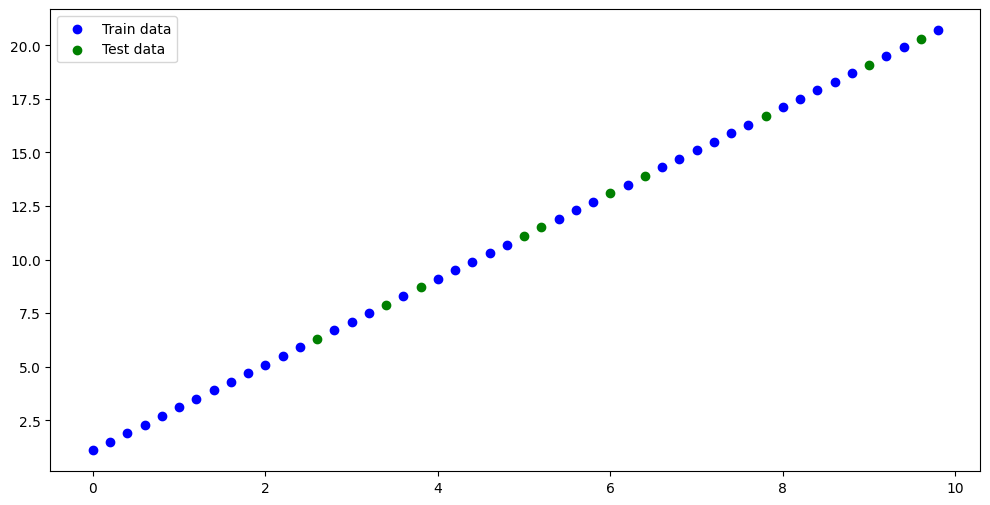

In [6]:
plot_pridictions()

# 1st pytorch model

In [7]:
# Create a model class
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
            